# 🔴 Tarea:

## Usando otro modelo tipo BERT (DeBERTa, ALBERT, ELECTRA, etc), realiza la tarea de clasificación en el dataset de reviews de turismo en español.

## Aquí hay dos desafios que explorar:

### 1. ¿Los modelos anteriores se pueden usar en español?

Para esta tarea, realiza una división *train/test* similar a la hecha en la práctica anterior con este dataset.

Para realizar el entrenamiento puedes usar la estrategia (1.A) o la clase `Trainer`.

**1. Preparación de los datos**

In [2]:
# Importar librerías 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Cargar datos de entrenamiento (train.csv)
train_df = pd.read_csv('Datos/train.csv')

# Preprocesar datos de entrenamiento
train_df['Text'] = train_df['Title'].astype(str) + " " + train_df['Opinion'].astype(str)  # Juntar opiniones y títulos
train_df = train_df.dropna()  # Eliminar filas con valores nulos

# Dividir datos de entrenamiento en conjunto de entrenamiento y validación (con estratificación)
X_train, X_val, y_train, y_val = train_test_split(
    train_df['Text'],
    train_df['Label'],
    test_size=0.15,  # 15% para validación
    random_state=42,
    stratify=train_df['Label']  # Estratificación para balancear las clases
)

# Calcular los pesos de las clases
class_weights = compute_class_weight(
    class_weight="balanced",  # Pesos inversamente proporcionales a la frecuencia de las clases
    classes=np.array([0, 1]), # Convertir a un arreglo de NumPy
    y=y_train.values          # Etiquetas del conjunto de entrenamiento
)

# Convertir los pesos a un tensor compatible con PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")

# Cargar datos de prueba (test_features.csv y test_labels.npy)
test_features = pd.read_csv('Datos/test_features.csv')  # Características
test_labels = np.load('Datos/test_labels.npy')          # Labels

# Preprocesar datos de prueba
test_features['Text'] = test_features['Title'].astype(str) + " " + test_features['Opinion'].astype(str)  # Juntar titulos y opiniones
test_features = test_features.dropna()  # Eliminar filas con valores nulos
X_test = test_features['Text']
y_test = test_labels

# Imprimir tamaños de los conjuntos de datos
print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de validación: {len(X_val)}")
print(f"Datos de prueba: {len(X_test)}")
# Imprimir pesos de las clases
print("\nPesos de las clases:", class_weights) 


Datos de entrenamiento: 3751
Datos de validación: 663
Datos de prueba: 780

Pesos de las clases: tensor([2.8503, 0.6064], device='cuda:0')


**2. Carga del modelo (ELECTRA) y tokenización**

In [3]:
#pip install transformers

Usaremos PyTorch, así que corroboaramos que todo esté en orden

In [4]:
import torch

print("Versión de PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre de GPU:", torch.cuda.get_device_name(0))

Versión de PyTorch: 2.5.1+cu118
CUDA disponible: True
Nombre de GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [5]:
# Crear un tensor y moverlo a la GPU
x = torch.tensor([1.0, 2.0, 3.0], device='cuda')
print("Tensor en GPU:", x)

# Realizar una operación en la GPU
y = x ** 2
print("Resultado de operación en GPU:", y)

Tensor en GPU: tensor([1., 2., 3.], device='cuda:0')
Resultado de operación en GPU: tensor([1., 4., 9.], device='cuda:0')


In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Cargar el tokenizador y el modelo ELECTRA
MODEL_NAME = "google/electra-small-discriminator"  # Modelo ELECTRA pre-entrenado en inglés

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Clasificación binaria

# Función de tokenización para los datos
def tokenize_data(texts, tokenizer, max_length=128):
    """
    Tokeniza un conjunto de textos.
    :param texts: Lista o Series de textos.
    :param tokenizer: Tokenizador preentrenado.
    :param max_length: Longitud máxima de los tokens.
    :return: Diccionario con los tensores tokenizados.
    """
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenización de los conjuntos de datos
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

# Verificar dimensiones de los tensores tokenizados
print(f"\nTamaño del conjunto de entrenamiento tokenizado: {train_encodings['input_ids'].shape}")
print(f"Tamaño del conjunto de validación tokenizado: {val_encodings['input_ids'].shape}")
print(f"Tamaño del conjunto de prueba tokenizado: {test_encodings['input_ids'].shape}")


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tamaño del conjunto de entrenamiento tokenizado: torch.Size([3751, 128])
Tamaño del conjunto de validación tokenizado: torch.Size([663, 128])
Tamaño del conjunto de prueba tokenizado: torch.Size([780, 128])


**3. Configuración y entrenamiento del modelo**

In [7]:
#pip install datasets

In [8]:
#pip install transformers[torch]

In [9]:
from transformers import TrainingArguments, Trainer
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset

# Crear una función de pérdida personalizada con los pesos de las clases
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Definir el Trainer personalizado para incluir la función de pérdida
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Sobrescribe la función de pérdida del Trainer para incluir Class Weights.
        """
        labels = inputs.pop("labels")  # Extraer etiquetas reales
        outputs = model(**inputs)      # Forward pass
        logits = outputs.logits        # Salidas del modelo
        loss = loss_fn(logits, labels) # Calcular pérdida con pesos
        return (loss, outputs) if return_outputs else loss

# Convertir los datos tokenizados y etiquetas en Datasets compatibles con Hugging Face
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": torch.tensor(y_train.values)
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": torch.tensor(y_val.values)
})

# Configuración del entrenamiento
training_args = TrainingArguments(
    output_dir="./results",                # Directorio para guardar los resultados
    evaluation_strategy="epoch",          # Evaluar al final de cada época
    save_strategy="epoch",                # Guardar modelo al final de cada época
    learning_rate=1e-5,                   # Tasa de aprendizaje ajustada
    per_device_train_batch_size=16,       # Tamaño del batch de entrenamiento
    per_device_eval_batch_size=16,        # Tamaño del batch de evaluación
    num_train_epochs=5,                   # Número de épocas
    weight_decay=0.01,                    # Decaimiento de peso (regularización)
    load_best_model_at_end=True,          # Cargar el mejor modelo al final
    metric_for_best_model="accuracy",     # Métrica para seleccionar el mejor modelo
    logging_dir="./logs",                 # Directorio para logs
    logging_steps=10,                     # Frecuencia de logs
    gradient_accumulation_steps=2,        # Acumulación de gradiente
    fp16=True,                            # Entrenamiento en precisión mixta
    report_to="none",                     # Deshabilitar reporte a servicios externos
)

# Función de métricas personalizada
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Configurar el Trainer
trainer = CustomTrainer(
    model=model,                         # Modelo a entrenar
    args=training_args,                  # Argumentos de entrenamiento
    train_dataset=train_dataset,         # Conjunto de entrenamiento
    eval_dataset=val_dataset,            # Conjunto de validación
    tokenizer=tokenizer,                 # Tokenizador
    compute_metrics=compute_metrics,     # Función de métricas personalizada
)

# Entrenamiento
trainer.train()

# Evaluación final en el conjunto de validación
eval_results = trainer.evaluate()
print("Resultados de evaluación:", eval_results)


c:\Users\jcbar\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\jcbar\AppData\Local\Temp\ipykernel_19704\2329405604.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


  0%|          | 0/585 [00:00<?, ?it/s]

{'loss': 0.697, 'grad_norm': 1.0945395231246948, 'learning_rate': 9.82905982905983e-06, 'epoch': 0.09}
{'loss': 0.6933, 'grad_norm': 1.1029469966888428, 'learning_rate': 9.658119658119659e-06, 'epoch': 0.17}
{'loss': 0.6915, 'grad_norm': 1.9477636814117432, 'learning_rate': 9.487179487179487e-06, 'epoch': 0.26}
{'loss': 0.6918, 'grad_norm': 2.510732412338257, 'learning_rate': 9.316239316239318e-06, 'epoch': 0.34}
{'loss': 0.6887, 'grad_norm': 1.636818289756775, 'learning_rate': 9.145299145299145e-06, 'epoch': 0.43}
{'loss': 0.6906, 'grad_norm': 2.5530776977539062, 'learning_rate': 8.974358974358976e-06, 'epoch': 0.51}
{'loss': 0.6826, 'grad_norm': 1.6540602445602417, 'learning_rate': 8.803418803418804e-06, 'epoch': 0.6}
{'loss': 0.6821, 'grad_norm': 1.514829158782959, 'learning_rate': 8.632478632478633e-06, 'epoch': 0.68}
{'loss': 0.6852, 'grad_norm': 3.0958611965179443, 'learning_rate': 8.461538461538462e-06, 'epoch': 0.77}
{'loss': 0.6884, 'grad_norm': 2.0136570930480957, 'learning_r

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.6718094348907471, 'eval_accuracy': 0.7254901960784313, 'eval_f1': 0.7398684557998283, 'eval_runtime': 0.9251, 'eval_samples_per_second': 716.659, 'eval_steps_per_second': 45.399, 'epoch': 1.0}
{'loss': 0.6676, 'grad_norm': 1.8398867845535278, 'learning_rate': 7.948717948717949e-06, 'epoch': 1.02}
{'loss': 0.6739, 'grad_norm': 3.09171199798584, 'learning_rate': 7.77777777777778e-06, 'epoch': 1.11}
{'loss': 0.6696, 'grad_norm': 2.592952013015747, 'learning_rate': 7.606837606837607e-06, 'epoch': 1.19}
{'loss': 0.6617, 'grad_norm': 3.2406716346740723, 'learning_rate': 7.435897435897437e-06, 'epoch': 1.28}
{'loss': 0.664, 'grad_norm': 2.220327377319336, 'learning_rate': 7.264957264957266e-06, 'epoch': 1.36}
{'loss': 0.666, 'grad_norm': 5.979058742523193, 'learning_rate': 7.0940170940170945e-06, 'epoch': 1.45}
{'loss': 0.6572, 'grad_norm': 3.1450088024139404, 'learning_rate': 6.923076923076923e-06, 'epoch': 1.53}
{'loss': 0.642, 'grad_norm': 6.520618438720703, 'learning_rate'

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.6355593800544739, 'eval_accuracy': 0.6817496229260935, 'eval_f1': 0.7182073254837084, 'eval_runtime': 0.9066, 'eval_samples_per_second': 731.295, 'eval_steps_per_second': 46.326, 'epoch': 2.0}
{'loss': 0.6431, 'grad_norm': 3.6699633598327637, 'learning_rate': 5.897435897435898e-06, 'epoch': 2.04}
{'loss': 0.6396, 'grad_norm': 9.442760467529297, 'learning_rate': 5.726495726495727e-06, 'epoch': 2.13}
{'loss': 0.6251, 'grad_norm': 3.6403985023498535, 'learning_rate': 5.555555555555557e-06, 'epoch': 2.21}
{'loss': 0.6235, 'grad_norm': 5.93582010269165, 'learning_rate': 5.384615384615385e-06, 'epoch': 2.3}
{'loss': 0.6246, 'grad_norm': 5.894554138183594, 'learning_rate': 5.213675213675214e-06, 'epoch': 2.38}
{'loss': 0.6202, 'grad_norm': 3.343411445617676, 'learning_rate': 5.042735042735043e-06, 'epoch': 2.47}
{'loss': 0.6192, 'grad_norm': 8.596417427062988, 'learning_rate': 4.871794871794872e-06, 'epoch': 2.55}
{'loss': 0.6381, 'grad_norm': 4.7870917320251465, 'learning_rat

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.6052986979484558, 'eval_accuracy': 0.7692307692307693, 'eval_f1': 0.786821569165517, 'eval_runtime': 0.9129, 'eval_samples_per_second': 726.292, 'eval_steps_per_second': 46.009, 'epoch': 3.0}
{'loss': 0.6261, 'grad_norm': 6.273568630218506, 'learning_rate': 3.846153846153847e-06, 'epoch': 3.06}
{'loss': 0.5946, 'grad_norm': 3.1554341316223145, 'learning_rate': 3.6752136752136756e-06, 'epoch': 3.15}
{'loss': 0.6065, 'grad_norm': 4.4549078941345215, 'learning_rate': 3.5042735042735045e-06, 'epoch': 3.23}
{'loss': 0.6001, 'grad_norm': 5.438844680786133, 'learning_rate': 3.3333333333333333e-06, 'epoch': 3.32}
{'loss': 0.5801, 'grad_norm': 4.572556018829346, 'learning_rate': 3.1623931623931626e-06, 'epoch': 3.4}
{'loss': 0.5935, 'grad_norm': 10.837342262268066, 'learning_rate': 2.9914529914529914e-06, 'epoch': 3.49}
{'loss': 0.5967, 'grad_norm': 5.04506778717041, 'learning_rate': 2.8205128205128207e-06, 'epoch': 3.57}
{'loss': 0.6292, 'grad_norm': 12.695109367370605, 'learni

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.59459388256073, 'eval_accuracy': 0.6711915535444947, 'eval_f1': 0.7104681972987504, 'eval_runtime': 0.8686, 'eval_samples_per_second': 763.287, 'eval_steps_per_second': 48.353, 'epoch': 4.0}
{'loss': 0.5995, 'grad_norm': 12.873221397399902, 'learning_rate': 1.794871794871795e-06, 'epoch': 4.09}
{'loss': 0.5753, 'grad_norm': 14.315138816833496, 'learning_rate': 1.623931623931624e-06, 'epoch': 4.17}
{'loss': 0.5935, 'grad_norm': 3.968071222305298, 'learning_rate': 1.4529914529914531e-06, 'epoch': 4.26}
{'loss': 0.5807, 'grad_norm': 5.796695232391357, 'learning_rate': 1.282051282051282e-06, 'epoch': 4.34}
{'loss': 0.5782, 'grad_norm': 4.635676860809326, 'learning_rate': 1.111111111111111e-06, 'epoch': 4.43}
{'loss': 0.5677, 'grad_norm': 6.5559163093566895, 'learning_rate': 9.401709401709402e-07, 'epoch': 4.51}
{'loss': 0.6187, 'grad_norm': 10.054391860961914, 'learning_rate': 7.692307692307694e-07, 'epoch': 4.6}
{'loss': 0.5778, 'grad_norm': 7.382168292999268, 'learning_ra

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.5851173400878906, 'eval_accuracy': 0.6998491704374057, 'eval_f1': 0.7343758588991689, 'eval_runtime': 0.9028, 'eval_samples_per_second': 734.345, 'eval_steps_per_second': 46.52, 'epoch': 4.98}
{'train_runtime': 79.001, 'train_samples_per_second': 237.402, 'train_steps_per_second': 7.405, 'train_loss': 0.6325558605357113, 'epoch': 4.98}


  0%|          | 0/42 [00:00<?, ?it/s]

Resultados de evaluación: {'eval_loss': 0.6052986979484558, 'eval_accuracy': 0.7692307692307693, 'eval_f1': 0.786821569165517, 'eval_runtime': 0.9482, 'eval_samples_per_second': 699.185, 'eval_steps_per_second': 44.292, 'epoch': 4.9787234042553195}


**4. Evaluación del Modelo (validación)**

  0%|          | 0/42 [00:00<?, ?it/s]

Reporte de clasificación:
                    precision    recall  f1-score   support

Clase 0 (Negativo)       0.53      0.40      0.45       116
Clase 1 (Positivo)       0.88      0.93      0.90       547

          accuracy                           0.83       663
         macro avg       0.70      0.66      0.68       663
      weighted avg       0.82      0.83      0.82       663



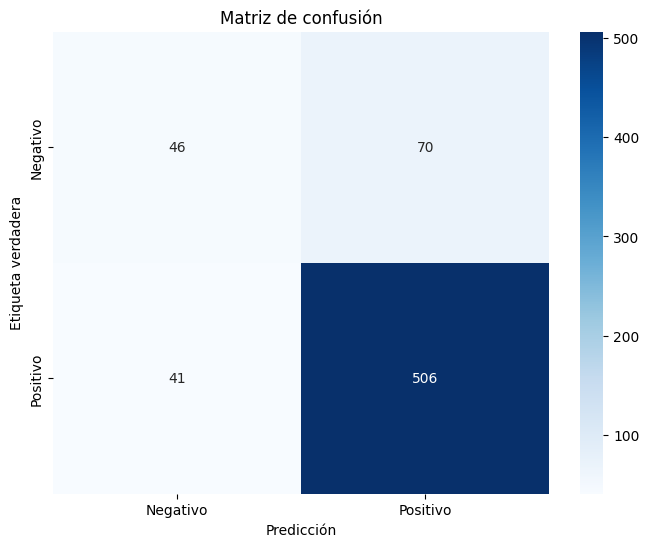

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de validación
predictions = trainer.predict(val_dataset)

# Umbral personalizado
threshold = 0.39 # Ajusta este valor según el balance deseado entre precisión y recall

# Obtener las probabilidades de la clase positiva
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()

# Clasificar usando el umbral personalizado
preds = (probs > threshold).astype(int)

# Generar reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_val, preds, target_names=["Clase 0 (Negativo)", "Clase 1 (Positivo)"]))

# Matriz de confusión
conf_matrix = confusion_matrix(y_val, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de confusión")
plt.show()


In [11]:
# Ejemplos incorrectos
incorrect_indices = np.where(preds != y_val.values)[0]
print(f"\nTotal de ejemplos mal clasificados: {len(incorrect_indices)}")
print("\nEjemplos de predicciones incorrectas:")
for idx in incorrect_indices[:3]:  # Mostrar 5 ejemplos
    print(f"\nTexto: {X_val.iloc[idx]}")
    print(f"Etiqueta verdadera: {y_val.iloc[idx]}, Predicción: {preds[idx]}")


Total de ejemplos mal clasificados: 111

Ejemplos de predicciones incorrectas:

Texto: "Vista espectacular" "La vista de la ciudad y los alrededores es lo mejor de todo, si te gusta subir escaleras puedes optar por recorrerlas de subida y de bajada, si no existe el funicular para subir. Es parte indispensable al ir a Guanajuato."
Etiqueta verdadera: 0, Predicción: 1

Texto: "Reconocer lo conocido" "Hace como 20 años que no volví a y ahora me parece un museo más que un viejo galerón.  La cantidad de luz y la organización del lugar podría darle un poco de miedo a niños pequeños si no se les contó antes lo que iban a ver."
Etiqueta verdadera: 1, Predicción: 0

Texto: "Gran inmueble que debe visitarse" "Es un lugar que se debe visitar para poder apreciar lo que ha aportado éste inmueble a todas las personas que han pisado sus instalaciones. Normalmente está en remodelación y regularmente presentan diferentes proyectos culturales en sus salas…"
Etiqueta verdadera: 1, Predicción: 0


In [12]:
# Ejemplos incorrectos
correct_indices = np.where(preds == y_val.values)[0]
print(f"\nTotal de ejemplos correctamente clasificados: {len(correct_indices)}")
print("\nEjemplos de predicciones correctas:")
for idx in correct_indices[:3]:  # Mostrar 5 ejemplos
    print(f"\nTexto: {X_val.iloc[idx]}")
    print(f"Etiqueta verdadera: {y_val.iloc[idx]}, Predicción: {preds[idx]}")


Total de ejemplos correctamente clasificados: 552

Ejemplos de predicciones correctas:

Texto: "Fascinante" "Todo en Guanajuato tiene una historia y aquí dice que solo quien llegue a ser profesionista podrá llegar al final de las escaleras y tocar la puerta 😊 es un edificio hermoso que indudablemente te gustará."
Etiqueta verdadera: 1, Predicción: 1

Texto: "Pintoresco" "Una parada oficial si va uno a Guanajuato , mi sugerencia es ir con la Cervantina que hace la noche más agradable , una ciudad encantadora con más historia que la que uno piensa."
Etiqueta verdadera: 1, Predicción: 1

Texto: "¿Vale la pena la espera?" "Lo he visitado en 2 ocasiones distintas. En ambas, el tiempo de espera ha sido exagerado, hasta de hora y media. Una vez dentro, considero que se trata de un atractivo único en todo México, pero del que puedes prescindir sin problema. El recorrido es bastante corto (15 - 20 min) y para colmo las explicaciones por parte de los guías se han simplificado bastante, debido a

**5. Evaluación del Modelo (test)**

  0%|          | 0/49 [00:00<?, ?it/s]

Reporte de clasificación en conjunto de prueba:
                    precision    recall  f1-score   support

Clase 0 (Negativo)       0.51      0.40      0.45       137
Clase 1 (Positivo)       0.88      0.92      0.90       643

          accuracy                           0.83       780
         macro avg       0.69      0.66      0.67       780
      weighted avg       0.81      0.83      0.82       780



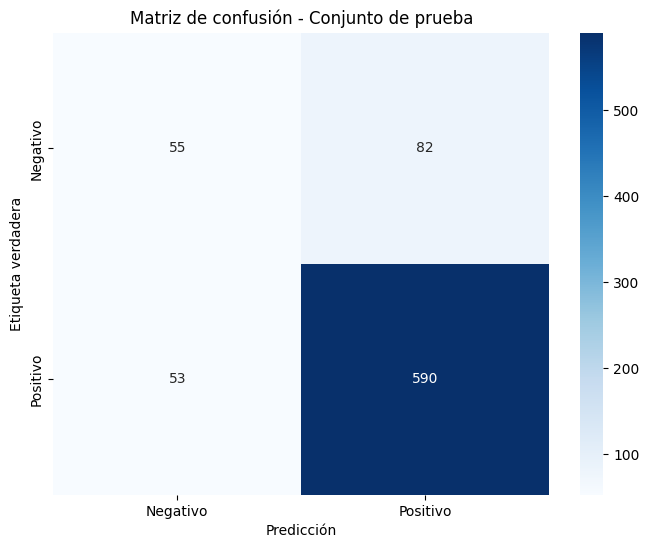

In [ ]:
from datasets import Dataset
import torch

# Convertir el conjunto de prueba en un Dataset compatible
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": torch.tensor(y_test)  # Agregar etiquetas de prueba
})

# Realizar predicciones en el conjunto de prueba
test_predictions = trainer.predict(test_dataset)

# Aplicar el umbral ajustado
threshold = 0.39  
test_probs = torch.softmax(torch.tensor(test_predictions.predictions), dim=-1)[:, 1].numpy()
test_preds = (test_probs > threshold).astype(int)

# Generar reporte de clasificación
print("Reporte de clasificación en conjunto de prueba:")
print(classification_report(y_test, test_preds, target_names=["Clase 0 (Negativo)", "Clase 1 (Positivo)"]))

# Matriz de confusión
test_conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de confusión - Conjunto de prueba")
plt.show()


In [14]:
# Ejemplos incorrectos en el conjunto de prueba
test_incorrect_indices = np.where(test_preds != y_test)[0]
print(f"\nTotal de ejemplos mal clasificados en conjunto de prueba: {len(test_incorrect_indices)}")
print("\nEjemplos de predicciones incorrectas en el conjunto de prueba:")
for idx in test_incorrect_indices[:3]:  # Mostrar los primeros 5 ejemplos
    print(f"\nTexto: {X_test.iloc[idx]}")
    print(f"Etiqueta verdadera: {y_test[idx]}, Predicción: {test_preds[idx]}")


Total de ejemplos mal clasificados en conjunto de prueba: 135

Ejemplos de predicciones incorrectas en el conjunto de prueba:

Texto: "Impresionante" "El acabado del altar es sumamente bonito, aunque considero que le falta un poco de mantenimiento, me parecio que estaba algo sucia aunque de noche se ve muy bonita."
Etiqueta verdadera: 0, Predicción: 1

Texto: "No hay mucho de Diego" "El museo está bien pero esperaba que hubiera más arte de Diego Rivera, en realidad son unos cuantos bocetos y cuadros y la mayoría de las salas exhiben arte de otros autores."
Etiqueta verdadera: 0, Predicción: 1

Texto: "Me desilusionó" "La verdad que la ciudad de Guanajuato necesita algo más moderno y bonito, esta muy corriente, y sucio."
Etiqueta verdadera: 0, Predicción: 1


In [15]:
# Ejemplos incorrectos en el conjunto de prueba
test_correct_indices = np.where(test_preds == y_test)[0]
print(f"\nTotal de ejemplos correctamente clasificados en conjunto de prueba: {len(test_correct_indices)}")
print("\nEjemplos de predicciones correctas en el conjunto de prueba:")
for idx in test_correct_indices[:3]:  # Mostrar los primeros 5 ejemplos
    print(f"\nTexto: {X_test.iloc[idx]}")
    print(f"Etiqueta verdadera: {y_test[idx]}, Predicción: {test_preds[idx]}")


Total de ejemplos correctamente clasificados en conjunto de prueba: 645

Ejemplos de predicciones correctas en el conjunto de prueba:

Texto: "No coman ahí" "Creo que es muy insalubre, hay basura por todos lados y aunque la comida es rica y barata, creo que se pueden visitar otros restaurantes."
Etiqueta verdadera: 0, Predicción: 0

Texto: "Romántico" "Es un callejón común donde todos toman fotos ya que 2 balcones estan muy próximos, pero no tiene nada de especial. Los lugareños aprovechan a contar leyendas sobre los enamorados."
Etiqueta verdadera: 0, Predicción: 0

Texto: Muy descuidado Cierto, es un mercado, pero no por eso hay que dejarlo caer. Es una pieza de valor histórico por el diseño del mismo y el arquitecto que lo imaginó. Está muy maltratado, espero que pronto entre a un programa de conservación que le devuelva el valor que realmente tiene.
Etiqueta verdadera: 0, Predicción: 0


### 2. Buscar un modelo específico en español.

Utilizaré el modelo de ELECTRA pre-entrenado en español "*skimai/electra-small-spanish*"

**1. Carga del modelo y tokenización**

In [54]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Cargar el tokenizador y el modelo preentrenado en español
MODEL_NAME = "skimai/electra-small-spanish"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Clasificación binaria

# Función de tokenización para los datos
def tokenize_data(texts, tokenizer, max_length=128):
    """
    Tokeniza un conjunto de textos.
    :param texts: Lista o Series de textos.
    :param tokenizer: Tokenizador preentrenado.
    :param max_length: Longitud máxima de los tokens.
    :return: Diccionario con los tensores tokenizados.
    """
    return tokenizer(list(texts), padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Tokenización de los conjuntos de datos
train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

# Verificar dimensiones de los tensores tokenizados
print(f"\nTamaño del conjunto de entrenamiento tokenizado: {train_encodings['input_ids'].shape}")
print(f"Tamaño del conjunto de validación tokenizado: {val_encodings['input_ids'].shape}")
print(f"Tamaño del conjunto de prueba tokenizado: {test_encodings['input_ids'].shape}")


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at skimai/electra-small-spanish and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tamaño del conjunto de entrenamiento tokenizado: torch.Size([3751, 128])
Tamaño del conjunto de validación tokenizado: torch.Size([663, 128])
Tamaño del conjunto de prueba tokenizado: torch.Size([780, 128])


**2. Configuración y entrenamiento del modelo**

In [30]:
from transformers import TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset

# Convertir los datos tokenizados y etiquetas en Datasets compatibles con Hugging Face
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": torch.tensor(y_train.values)
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": torch.tensor(y_val.values)
})

# Definir los pesos de las clases
class_weights = torch.tensor([2.85, 0.60], dtype=torch.float).to("cuda")  # Ajusta según el cálculo previo

# Configuración del entrenamiento
training_args = TrainingArguments(
    output_dir="./results",                # Directorio para guardar los resultados
    evaluation_strategy="epoch",          # Evaluar al final de cada época
    save_strategy="epoch",                # Guardar modelo al final de cada época
    learning_rate=1e-5,                   # Tasa de aprendizaje ajustada
    per_device_train_batch_size=16,       # Tamaño del batch de entrenamiento
    per_device_eval_batch_size=16,        # Tamaño del batch de evaluación
    num_train_epochs=5,                   # Número de épocas
    weight_decay=0.01,                    # Decaimiento de peso (regularización)
    load_best_model_at_end=True,          # Cargar el mejor modelo al final
    metric_for_best_model="accuracy",     # Métrica para seleccionar el mejor modelo
    logging_dir="./logs",                 # Directorio para logs
    logging_steps=10,                     # Frecuencia de logs
    gradient_accumulation_steps=2,        # Acumulación de gradiente
    report_to="none",                     # Deshabilitar reporte a servicios externos
)

# Función de métricas personalizada
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Crear una clase personalizada para añadir los pesos de clases
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # Aceptar argumentos adicionales con **kwargs
        labels = inputs["labels"]
        # Retirar las etiquetas del diccionario de entradas para evitar conflictos
        inputs = {k: v for k, v in inputs.items() if k != "labels"}
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)  # Añadir pesos de clases
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Configuración del Trainer
trainer = CustomTrainer(
    model=model,                         # Modelo a entrenar
    args=training_args,                  # Argumentos de entrenamiento
    train_dataset=train_dataset,         # Conjunto de entrenamiento
    eval_dataset=val_dataset,            # Conjunto de validación
    tokenizer=tokenizer,                 # Tokenizador
    compute_metrics=compute_metrics,     # Función de métricas personalizada
)

# Entrenamiento
trainer.train()

# Evaluación final en el conjunto de validación
eval_results = trainer.evaluate()
print("Resultados de evaluación:", eval_results)


C:\Users\jcbar\AppData\Local\Temp\ipykernel_19704\1419512968.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


  0%|          | 0/585 [00:00<?, ?it/s]

{'loss': 0.7125, 'grad_norm': 1.1266881227493286, 'learning_rate': 9.82905982905983e-06, 'epoch': 0.09}
{'loss': 0.7094, 'grad_norm': 0.8989396691322327, 'learning_rate': 9.658119658119659e-06, 'epoch': 0.17}
{'loss': 0.6862, 'grad_norm': 1.0243102312088013, 'learning_rate': 9.487179487179487e-06, 'epoch': 0.26}
{'loss': 0.6957, 'grad_norm': 2.4444491863250732, 'learning_rate': 9.316239316239318e-06, 'epoch': 0.34}
{'loss': 0.6905, 'grad_norm': 0.7810323238372803, 'learning_rate': 9.145299145299145e-06, 'epoch': 0.43}
{'loss': 0.6878, 'grad_norm': 1.0489976406097412, 'learning_rate': 8.974358974358976e-06, 'epoch': 0.51}
{'loss': 0.6709, 'grad_norm': 1.053371548652649, 'learning_rate': 8.803418803418804e-06, 'epoch': 0.6}
{'loss': 0.691, 'grad_norm': 1.068642497062683, 'learning_rate': 8.632478632478633e-06, 'epoch': 0.68}
{'loss': 0.6839, 'grad_norm': 2.5151753425598145, 'learning_rate': 8.461538461538462e-06, 'epoch': 0.77}
{'loss': 0.6856, 'grad_norm': 1.432358741760254, 'learning_r

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.6562442183494568, 'eval_accuracy': 0.8250377073906485, 'eval_f1': 0.7459431833763385, 'eval_runtime': 0.9129, 'eval_samples_per_second': 726.255, 'eval_steps_per_second': 46.007, 'epoch': 1.0}
{'loss': 0.6512, 'grad_norm': 1.1500791311264038, 'learning_rate': 7.948717948717949e-06, 'epoch': 1.02}
{'loss': 0.6652, 'grad_norm': 1.9958230257034302, 'learning_rate': 7.77777777777778e-06, 'epoch': 1.11}
{'loss': 0.6515, 'grad_norm': 2.6328041553497314, 'learning_rate': 7.606837606837607e-06, 'epoch': 1.19}
{'loss': 0.6411, 'grad_norm': 1.5808684825897217, 'learning_rate': 7.435897435897437e-06, 'epoch': 1.28}
{'loss': 0.643, 'grad_norm': 1.486473798751831, 'learning_rate': 7.264957264957266e-06, 'epoch': 1.36}
{'loss': 0.6377, 'grad_norm': 3.8347365856170654, 'learning_rate': 7.0940170940170945e-06, 'epoch': 1.45}
{'loss': 0.6239, 'grad_norm': 2.0479421615600586, 'learning_rate': 6.923076923076923e-06, 'epoch': 1.53}
{'loss': 0.6079, 'grad_norm': 2.766408920288086, 'learning

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.5905080437660217, 'eval_accuracy': 0.8235294117647058, 'eval_f1': 0.8366888075947069, 'eval_runtime': 0.8428, 'eval_samples_per_second': 786.643, 'eval_steps_per_second': 49.833, 'epoch': 2.0}
{'loss': 0.6004, 'grad_norm': 2.6159210205078125, 'learning_rate': 5.897435897435898e-06, 'epoch': 2.04}
{'loss': 0.6081, 'grad_norm': 1.4784998893737793, 'learning_rate': 5.726495726495727e-06, 'epoch': 2.13}
{'loss': 0.5934, 'grad_norm': 2.433769941329956, 'learning_rate': 5.555555555555557e-06, 'epoch': 2.21}
{'loss': 0.5874, 'grad_norm': 2.1614537239074707, 'learning_rate': 5.384615384615385e-06, 'epoch': 2.3}
{'loss': 0.5761, 'grad_norm': 1.7561728954315186, 'learning_rate': 5.213675213675214e-06, 'epoch': 2.38}
{'loss': 0.5716, 'grad_norm': 2.396782636642456, 'learning_rate': 5.042735042735043e-06, 'epoch': 2.47}
{'loss': 0.5833, 'grad_norm': 4.042447566986084, 'learning_rate': 4.871794871794872e-06, 'epoch': 2.55}
{'loss': 0.5838, 'grad_norm': 2.7408194541931152, 'learning_

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.5566052794456482, 'eval_accuracy': 0.7948717948717948, 'eval_f1': 0.8145778717967673, 'eval_runtime': 0.82, 'eval_samples_per_second': 808.514, 'eval_steps_per_second': 51.218, 'epoch': 3.0}
{'loss': 0.5467, 'grad_norm': 3.574913501739502, 'learning_rate': 3.846153846153847e-06, 'epoch': 3.06}
{'loss': 0.581, 'grad_norm': 3.0220019817352295, 'learning_rate': 3.6752136752136756e-06, 'epoch': 3.15}
{'loss': 0.574, 'grad_norm': 2.1112382411956787, 'learning_rate': 3.5042735042735045e-06, 'epoch': 3.23}
{'loss': 0.5541, 'grad_norm': 2.179595947265625, 'learning_rate': 3.3333333333333333e-06, 'epoch': 3.32}
{'loss': 0.5341, 'grad_norm': 3.618656635284424, 'learning_rate': 3.1623931623931626e-06, 'epoch': 3.4}
{'loss': 0.55, 'grad_norm': 2.1739721298217773, 'learning_rate': 2.9914529914529914e-06, 'epoch': 3.49}
{'loss': 0.5838, 'grad_norm': 4.114546298980713, 'learning_rate': 2.8205128205128207e-06, 'epoch': 3.57}
{'loss': 0.5802, 'grad_norm': 5.506147384643555, 'learning_ra

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.5367790460586548, 'eval_accuracy': 0.8416289592760181, 'eval_f1': 0.853169798301235, 'eval_runtime': 0.8839, 'eval_samples_per_second': 750.111, 'eval_steps_per_second': 47.518, 'epoch': 4.0}
{'loss': 0.5696, 'grad_norm': 3.706066846847534, 'learning_rate': 1.794871794871795e-06, 'epoch': 4.09}
{'loss': 0.5484, 'grad_norm': 2.2439351081848145, 'learning_rate': 1.623931623931624e-06, 'epoch': 4.17}
{'loss': 0.5354, 'grad_norm': 2.2898471355438232, 'learning_rate': 1.4529914529914531e-06, 'epoch': 4.26}
{'loss': 0.5291, 'grad_norm': 3.1780457496643066, 'learning_rate': 1.282051282051282e-06, 'epoch': 4.34}
{'loss': 0.539, 'grad_norm': 9.695121765136719, 'learning_rate': 1.111111111111111e-06, 'epoch': 4.43}
{'loss': 0.5625, 'grad_norm': 3.0747275352478027, 'learning_rate': 9.401709401709402e-07, 'epoch': 4.51}
{'loss': 0.568, 'grad_norm': 3.93734073638916, 'learning_rate': 7.692307692307694e-07, 'epoch': 4.6}
{'loss': 0.5285, 'grad_norm': 2.1740546226501465, 'learning_rat

  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.5322157740592957, 'eval_accuracy': 0.8220211161387632, 'eval_f1': 0.8373359373012673, 'eval_runtime': 0.85, 'eval_samples_per_second': 780.021, 'eval_steps_per_second': 49.413, 'epoch': 4.98}
{'train_runtime': 79.0562, 'train_samples_per_second': 237.236, 'train_steps_per_second': 7.4, 'train_loss': 0.6030530933640961, 'epoch': 4.98}


  0%|          | 0/42 [00:00<?, ?it/s]

Resultados de evaluación: {'eval_loss': 0.5367790460586548, 'eval_accuracy': 0.8416289592760181, 'eval_f1': 0.853169798301235, 'eval_runtime': 0.9435, 'eval_samples_per_second': 702.671, 'eval_steps_per_second': 44.513, 'epoch': 4.9787234042553195}


**3. Evaluación del modelo (validación)**

  0%|          | 0/42 [00:00<?, ?it/s]

Reporte de clasificación en conjunto de validación:
                    precision    recall  f1-score   support

Clase 0 (Negativo)       0.70      0.59      0.64       116
Clase 1 (Positivo)       0.92      0.95      0.93       547

          accuracy                           0.89       663
         macro avg       0.81      0.77      0.79       663
      weighted avg       0.88      0.89      0.88       663



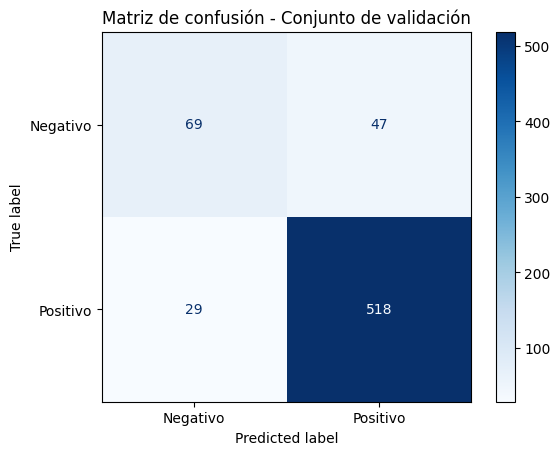

In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Realizar predicciones en el conjunto de validación
val_predictions = trainer.predict(val_dataset)

# Aplicar el umbral ajustado
threshold = 0.40  # Ajusta este valor si es necesario
probs = torch.nn.functional.softmax(torch.tensor(val_predictions.predictions), dim=-1)  # Obtener probabilidades
pred_labels = (probs[:, 1] > threshold).int()  # Etiquetas predichas con el umbral ajustado

# Generar métricas de evaluación
print("Reporte de clasificación en conjunto de validación:")
print(classification_report(y_val, pred_labels, target_names=["Clase 0 (Negativo)", "Clase 1 (Positivo)"]))

# Matriz de confusión
cm = confusion_matrix(y_val, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativo", "Positivo"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Conjunto de validación")
plt.show()


**4. Evaluación del modelo (test)**

  0%|          | 0/49 [00:00<?, ?it/s]

Reporte de clasificación en conjunto de prueba:
                    precision    recall  f1-score   support

Clase 0 (Negativo)       0.76      0.56      0.65       137
Clase 1 (Positivo)       0.91      0.96      0.94       643

          accuracy                           0.89       780
         macro avg       0.84      0.76      0.79       780
      weighted avg       0.89      0.89      0.89       780



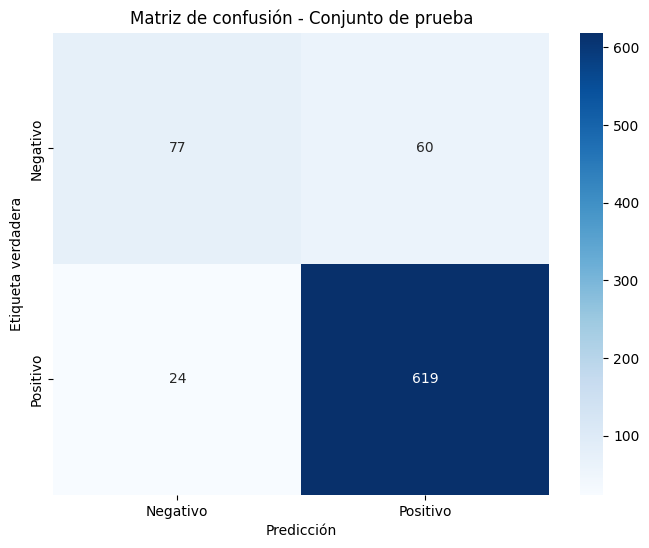

In [52]:
from datasets import Dataset
import torch

# Convertir el conjunto de prueba en un Dataset compatible
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": torch.tensor(y_test)  # Agregar etiquetas de prueba
})

# Realizar predicciones en el conjunto de prueba
test_predictions = trainer.predict(test_dataset)

# Aplicar el umbral ajustado
threshold = 0.40  # Ajusta este valor si es necesario
test_probs = torch.softmax(torch.tensor(test_predictions.predictions), dim=-1)[:, 1].numpy()
test_preds = (test_probs > threshold).astype(int)

# Generar reporte de clasificación
print("Reporte de clasificación en conjunto de prueba:")
print(classification_report(y_test, test_preds, target_names=["Clase 0 (Negativo)", "Clase 1 (Positivo)"]))

# Matriz de confusión
test_conf_matrix = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de confusión - Conjunto de prueba")
plt.show()